# Population genetics: deterministic and stochastic discrete time models
## Computational Science with Python
## Yoav Ram

In [317]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from IPython.display import Latex
import random
import sympy
import scipy.stats

We will start with a simple deterministic one-dimensional model, then develop a stochastic model that adds random sampling.

# Deterministic model

Consider a *vary large* population with two types, $A$ and $a$.
The fitness of $A$ relative to $a$ is $1+s$

> Fitness is the reproductive success, composed of survival, mating success, fecundity etc. When a trait that affects fitness is heritable -- the offspring have the same trait as the parent -- then it will tend to increase in frequency.

We denote the frequency of $A$ and $a$ as $p$ and $1-p$ and write an equation that describes the frequency of $A$ in the next generation, $p'$:

$$
p' = \frac{p (1+s)}{p (1+s) + 1-p}
$$

where $p (1+s) + 1-p$ is the mean fitness in the population, usually denoted $\bar w$.

This model is attributed to [Haldane 1924][(http://link.springer.com/article/10.1007%2FBF02459574).
![Haldane](https://www.biografiasyvidas.com/biografia/h/fotos/haldane.jpg)](https://en.wikipedia.org/wiki/J._B._S._Haldane)

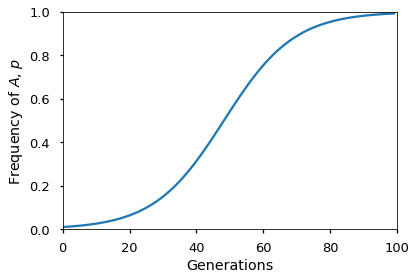

In [3]:
def evolution0(p0, s, tmax):
    p = [p0]

    for t in range(1, tmax):
        p.append( p[t-1] * (1 + s) / (1 + p[t-1] * s) )

    return p

p = evolution0(0.01, 0.1, 100)
plt.plot(p)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Let's see how fast evolution is for different strengths of selection.

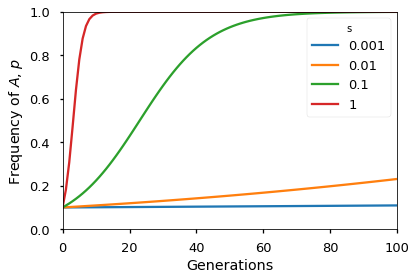

In [4]:
for s in (0.001, 0.01, 0.1, 1):
    plt.plot(evolution0(0.1, s, 100000), label=s)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p))
# plt.yscale('log')
plt.legend(title='s');

So the strength of selection has a hugh effect on the speed of evolution.

The recurrence equation from above ($p'=\ldots$) can be solved so that we have an equation of $p(t)$ as a function of time (generations).

Let's write the recurrence for $q_t=(1-p_t)$ the frequency of $a$ (it's just a bit easier):

$$
q_t = \frac{q_{t-1}}{q_t + (1-q_t)(1+s)} = \\
\frac{q_{t-1}}{1-s(1-q_t)} = 
$$

If we write the formula for $q_1$ and $q_2$ we can get

$$
q_2 = \frac{q_0}{q_0 + (1-q_0)(1+s)^2}
$$

which hints at 

$$
q_t = \frac{q_0}{q_0 + (1-q_0)(1+s)^t}
$$

and quivalently

$$
p_t = 1 - \frac{1-p_0}{1-p_0 + p_0(1+s)^t}
$$


Let's check it numerically:

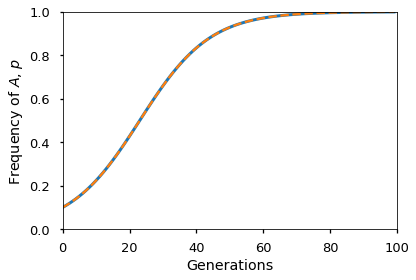

In [31]:
def evolution1(p0, s, tmax):
    return [
        1 - (1-p0)/(1 - p0 + p0 * (1 + s)**t)
        for t in range(int(tmax))
    ]

plt.plot(evolution0(0.1, 0.1, 100), lw=3, label='recurrence')
plt.plot(evolution1(0.1, 0.1, 100), '--', label='solution')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Looks good, so we can try and prove it using induction:

$$
q_{t+1} = \frac{q_t}{1+s(1-q_t)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s\Big(1-\frac{q_0}{q_0 + (1-q_0)(1+s)^t}\Big)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s-\frac{sq_0}{q_0 + (1-q_0)(1+s)^t}} = \\
\frac{q_0}{(1+s)(q_0 + (1-q_0)(1+s)^t) - sq_0} = \\
\frac{q_0}{q_0+s q_0 + (1-q_0)(1+s)(1+s)^{t}) - sq_0} = \\
\frac{q_0}{q_0 + (1-q_0)(1+s)^{t+1})}
$$

which proves the induction.

## Fixation time (deterministic)

Using the closed-form solution we can find the time for increase from some low frequency $p_0$ to a high frequency $1-p_0$, which will give us to approximate time it takes type $A$ to dominate the population when it is initially rare.

We need to solve the following for $t$:

$$
1-p_0 = 1-\frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
p_0 = \frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
(1+s)^t = \frac{(1-p_0)^2}{p_0^2}
$$

Taking the log of both sides

$$
t  = \frac{2\log{(1-p_0)/p_0} }{log (1+s)}
$$

If we assume that $p_0\sim 0$ so $(1-p_0)/p_0 \sim p_0^{-1}$ then

$$
t  = \frac{-2\log{p_0}}{log (1+s)}
$$



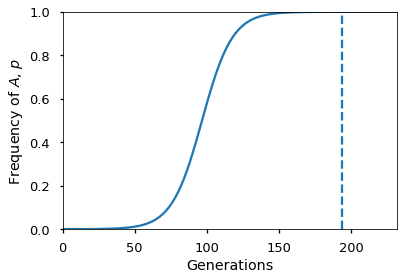

In [32]:
p0 = 1e-4
s = 0.1
t = -2 * np.log(p0) / np.log(1+s)

plt.plot(evolution1(p0, s, 1.2*t), '-')
plt.axvline(t, ls='--')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 1.2*t);

Of course, the assumption of a very large population breaks when either the population size is not very large, leading to stochastic effects, or when the population is very large but one of the type is extermely rare.

Let's start with the second case.

# Stochastic model: large population

Let's start with a stochastic model for a large population.

We will use a **branching process*.

For simplicity, we assume that the number of offspring per individual is Poisson distributed, with mean $1$ for type $a$ and $1+s$ for type $A$.

So the probability that an $A$ individual leaves $k$ offspring is

$$
P(k) = e^{-(1+s)}\frac{(1+s)^k}{k!}
$$

From Otto and Day 2007 (ch. 14.5):

> The key insight made by Haldane (1927) was that the probability that a type ultimately leaves no descendants must equal the probability that each offspring produced by this type leaves no descendants.

So we can write

$$
p_{loss} = \sum_{k=0}^{\infty}{p_{loss}^k P(k)} = \\
e^{-(1+s)} \sum_{k=0}^{\infty}{\frac{\big((1+s)p_{loss}\big)^k}{k!}} = \\
e^{-(1+s)} e^{p_{loss}(1+s)}
$$

where the last transition is due to the Taylor expansion on the exponential function.

So we get 

$$
p_{loss} = e^{-(1-p_{loss})(1+s)}
$$

We can find a solution with sympy:

In [49]:
p, s = sympy.symbols('p s')
sol = sympy.solve(p-sympy.exp(-(1-p)*(1+s)), p)[0]

Latex(sympy.latex(sol, mode='inline'))

<IPython.core.display.Latex object>

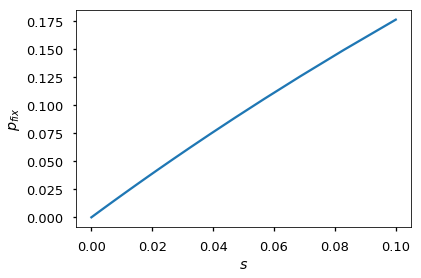

In [64]:
s = np.logspace(-5, -1)
pfix = [1-sol.evalf(subs=dict(s=s_)) for s_ in s]

plt.plot(s, pfix)
plt.xlabel('$s$')
plt.ylabel('$p_{fix}$');

This solution is in terms of the [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function) which is fine for numerical applications, but not so much if we want to understand the result.

We can rewrite the formula in terms of $p_{fix}=1-p_{loss}$:

$$
p_{fix} = 1-e^{-(1+s)p_{fix}} 
$$

If we assume that $s$ and $p_{fix}$ are both small (i.e. porportional to some small $\epsilon$), we can use the Taylor expansion for the exponential function (again) to get, up to term of order $o(\epsilon^3)$,

$$
p_{fix} \approx (1+s)p_{fix} - \frac{1}{2}\big((1+s)p_{fix}\big)^2
$$

To solve this we do some algebra and use the quadratic formula

$$
p_{fix} - (1+s)p_{fix} + \frac{1}{2}\big((1+s)p_{fix}\big)^2 = 0 \Rightarrow \\
\frac{1}{2}(1+s)^2 p_{fix}^2 -s p_{fix} = 0 \Rightarrow \\
p_{fix} = \frac{s \pm s}{(1+s)^2}
$$

So we get that $p_{fix} \approx s\frac{s}{1+s}$, and since $s$ is small, we have $p_{fix} \approx 2s$.

Let's compare it to the full result from above:

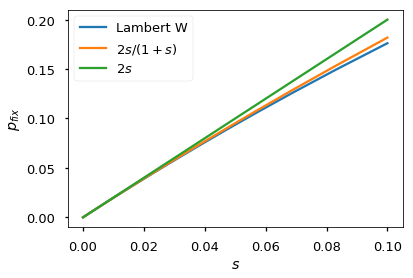

In [65]:
plt.plot(s, pfix, label='Lambert W')
plt.plot(s, 2*s/(1+s), label='$2s/(1+s)$')
plt.plot(s, 2*s, label='$2s$')
plt.xlabel('$s$')
plt.ylabel('$p_{fix}$')
plt.legend();

# Stochastic model: small population

In a small population, random effects can affect the dynamics even when neither type is extermely rare.

We will use the **Wright-Fisher model** and assume that at each generation, $n$ the number of individuals of type $A$ is binomially distributed $Bin(N, p)$ where $p$ is the frequency of $A$ offspring.

## Pure Python implementation

We implement the model using a pure Python function.

Of course, everytime we run the simulation we will get a different result.

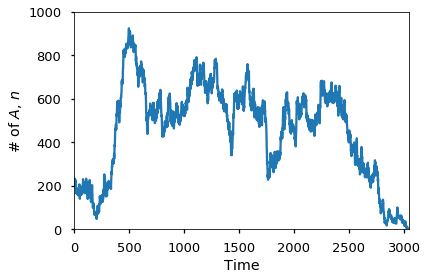

In [109]:
def simulation_py(n0, N, s):
    n = [n0]

    while 0 < n[-1] < N:
        p = n[-1] * (1 + s) / (N + n[-1] * s)
        sample = (1 for _ in range(N) if random.random() < p)
        n.append(sum(sample))

    return n

n0, N, s = 200, 1000, 0.001
n = simulation_py(n0, N, s)
plt.plot(n)
plt.xlabel('Time')
plt.ylabel('# of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [135]:
%timeit simulation_py(n0=200, N=1000, s=0.1)
%timeit simulation_py(n0=2000, N=10000, s=0.01)

11.7 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.04 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can do better (faster?) than that.

## NumPy implementation

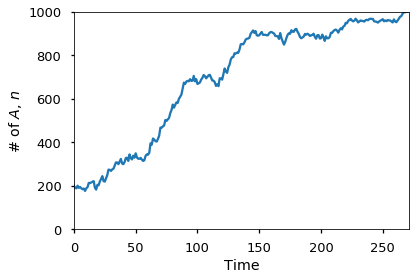

In [136]:
def simulation_np(n0, N, s, buflen=1000):
    n = np.empty(buflen)
    n[0] = n0
    t = 0
    while 0 < n[t] < N:        
        p = n[t] * (1 + s) / (N + n[t] * s)
        t += 1
        if t == len(n):
            n = np.append(n, np.empty(buflen))
        n[t] = np.random.binomial(N, p)

    return n[:t+1].copy()

n0, N, s = 200, 1000, 0.01
n = simulation_np(n0, N, s)
plt.plot(n)
plt.xlabel('Time')
plt.ylabel('# of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [138]:
%timeit simulation_np(n0=200, N=1000, s=0.1)
%timeit simulation_np(n0=2000, N=10000, s=0.1)

263 µs ± 6.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
367 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This is much faster than the pure Python implementation.

Can we do better?

# Multiple simulations

## Pure Python

In [143]:
def simulations_py(n0, N, s, repetitions=10):
    return [
        simulation_py(n0, N, s) 
        for _ in range(repetitions)
    ]

n = simulations_py(n0, N, s, 100)

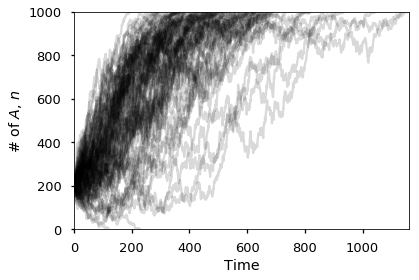

In [147]:
for n_ in n:
    plt.plot(n_, 'k', alpha=0.15)
plt.xlabel('Time')
plt.ylabel('# of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, max(len(n_) for n_ in n));

In [148]:
%timeit simulations_py(200, 1000, 0.01, 100)

7.6 s ± 490 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## NumPy

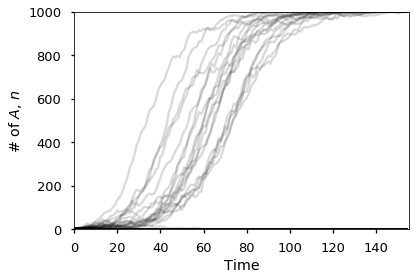

In [252]:
def simulations_np(n0, N, s, repetitions=10, buflen=1000):
    n = np.zeros((buflen, repetitions))
    n[0,:] = n0
    t = 0
    update = (n[t] > 0) & (n[t] < N)
    while update.any():
        t += 1
        p = n[t-1] * (1 + s) / (N + n[t-1] * s)
        if t == n.shape[0]:
            n = np.concatenate((n, np.zeros((buflen, repetitions))))
        n[t, update] = np.random.binomial(N, p[update])
        n[t, ~update] = n[t-1, ~update]
        update = (n[t] > 0) & (n[t] < N)

    return n[:t].copy()

n = simulations_np(n0, N, s, 100)
plt.plot(n, 'k', alpha=0.15)
plt.xlabel('Time')
plt.ylabel('# of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, n.shape[0]);

In [253]:
n

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 2., 3., ..., 0., 1., 1.],
       [0., 2., 3., ..., 0., 2., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

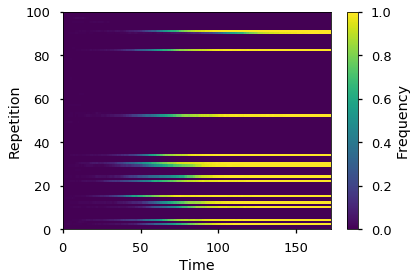

In [247]:
plt.pcolormesh(n.T/1000)
plt.colorbar(label='Frequency')
plt.xlabel('Time')
plt.ylabel('Repetition');

In [248]:
%timeit simulations_np(n0=200, N=1000, s=0.1, repetitions=1000)
%timeit simulations_np(n0=2000, N=10000, s=0.01, repetitions=1000)

19.1 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
164 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Fixation probability

If we want to estimate the fixation probability, we don't actually need to save the entire $n$ array.

In [377]:
def fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)

    return (n == N).mean()

fix_prob(1, 100, 0.1, 100000)

0.17708

In [294]:
%timeit n=simulations_np(1, 100, 0.1, 100000);# (n[-1,:]==N).mean()
%timeit fix_prob(1, 100, 0.1, 100000)

775 ms ± 55.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
427 ms ± 49.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [378]:
Ns = np.logspace(1, 6, 100, dtype=int)
s = 0.001
n0 = 1

pfix = [fix_prob(n0, N, s, 1000) for N in Ns]

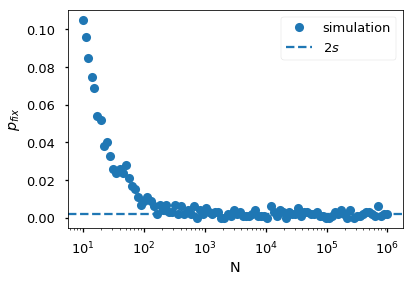

In [379]:
plt.plot(Ns, pfix, 'o', label='simulation')
plt.axhline(2*s/(1+s), ls='--', label='$2s$')

plt.xlabel('N')
plt.xscale('log')
plt.ylabel('$p_{fix}$')
plt.legend();

# Diffusion equation approximation for fixation probability

Using a diffusion equation approximation, [Kimura (1962)](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210364/) reached his famous equation:

$$
\frac{1 - e^{-2 n_0 s}}{1 - e^{-2 N s}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

[![Kimura](https://upload.wikimedia.org/wikipedia/en/4/48/Motoo_Kimura.jpg)](https://en.wikipedia.org/wiki/Motoo_Kimura)

In [380]:
def fix_kimura(n0, N, s):
    return np.expm1(-2 * n0 * s) / np.expm1(-2 * N * s)

Note the use of `expm1(x)` which is more precise than `exp(1-x)` for small `x` values.

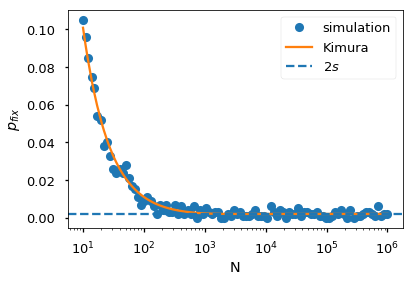

In [381]:
plt.plot(Ns, pfix, 'o', label='simulation')
plt.plot(Ns, fix_kimura(n0, Ns, s), '-', label='Kimura')
plt.axhline(2*s/(1+s), ls='--', label='$2s$')

plt.xlabel('N')
plt.xscale('log')
plt.ylabel('$p_{fix}$')
plt.legend();

This approximation does the job very well.

Behold the power of NumPy's `ufunc`:

In [299]:
Ns_ = np.logspace(1, 6, 5000, dtype=np.int64)
%timeit [kimura(n0, N, s) for N in Ns_]
%timeit kimura(n0, Ns_, s)

28.6 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.3 µs ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Numba

[Numba](http://numba.pydata.org/) is a JIT compiler for Python and NumPy built over LLVM



In [300]:
import numba

kimura_nm = numba.jit(kimura)
kimura_nm(n0, N, s); # burn-in for the jit to work

In [301]:
Ns = np.logspace(1, 6, 100, dtype=float)
%timeit kimura(n0, Ns, s)
%timeit kimura_nm(n0, Ns, s)

5.81 µs ± 63 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.49 µs ± 37 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [302]:
Ns = np.logspace(1, 6, 10000, dtype=float)
%timeit kimura(n0, Ns, s)
%timeit kimura_nm(n0, Ns, s)

80 µs ± 721 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
70.6 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Fixation time (stochastic)

Now we will focus on the time it takes for the fixation of one of the type to occur.

In [305]:
def fix_time(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T

In [331]:
n0 = 10
N = 1000
s = 0.01
fixations, times = fix_time(n0, N, s, 100000)

/Users/yoavram/miniconda3/envs/CompSciPy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


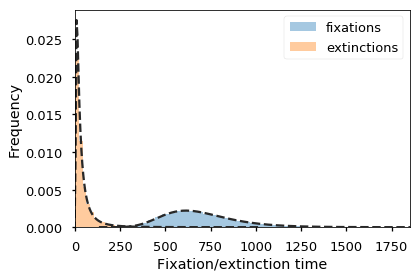

In [332]:
fig, ax = plt.subplots()
kwargs = dict(ax=ax, kde=False, fit=scipy.stats.exponweib, 
              fit_kws=dict(ls='--'))
sns.distplot(times[fixations], label='fixations', **kwargs)
sns.distplot(times[~fixations], label='extinctions', **kwargs)
ax.set(
    xlim=(0, -4 * np.log(n0/N) / np.log(1+s)),
    xlabel='Fixation/extinction time',
    ylabel='Frequency'
)
ax.legend();

In [392]:
def mean_std_fix_time(fixations, times):
    fix_times = times[fixations]
    return fix_times.mean(), fix_times.std(ddof=1)

n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01
fix_times = np.array([
    mean_std_fix_time(*fix_time(n0, N, s, 10000)) 
    for N in Ns
])

def T_haldane(n0, Ns, s):
    return -2 * np.log(n0/Ns) / np.log(1+s)

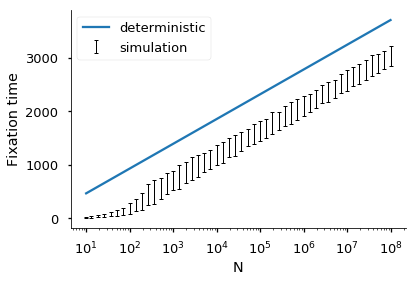

In [398]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulation',
             ecolor='k', elinewidth=1)
plt.plot(Ns, T_haldane(n0, Ns, s), label='deterministic')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

We can see that the deterministic approximation only works well at the very large population limit.

Can we have a better approximation?

## Diffusion equation approximation for fixation time

Another approximation of the fixation time is based on a diffusion equation and is given in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (eq. 17). It assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$. Also, it has the initial frequency as $x$, so we define $x=n_0/N$.

$$
I_1(x) = \frac{1 - e^{-2 n_0 s} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dt} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

`functools.partial` reduces the number of arguments a function expects, effectively freezing some of them - mathematically, it creates a projection.

`np.vectorize` is a decorator that converts a scalar function to an array function, giving it the `ufunc` super powers.

In [369]:
from scipy.integrate import quad 
from functools import partial

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]

In [370]:
def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1, 1e6, 0.1) < 255

Behold the power of `np.vectorize`.

In [374]:
Ns = np.logspace(1, 6, 100)
%timeit np.array([T_kimura(n0, N, s) for N in Ns])
%timeit T_kimura(n0, Ns, s)

283 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
114 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's compare the simulation results with the two approximations:

In [393]:
n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01

fix_time_kimura = T_kimura(n0, Ns, s)
fix_time_haldane = T_haldane(n0, Ns, s)

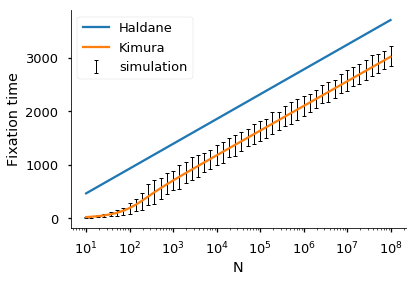

In [394]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulation',
             ecolor='k', elinewidth=1)
plt.plot(Ns, fix_time_haldane, label='Haldane')
plt.plot(Ns, fix_time_kimura, label='Kimura')

plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

Kimura's approximation is fantastic.

# Multi-type model

The above simulations are hard to extend for a multi-type model in which there are more than two types, because we used scalar arithmetics and the binomial distribution.

The following is the extension that uses matrix multiplication and the multinomial distribution.

There are now **L** types; the fitness of type **i** is $(1+s)^i$; type **i** can mutate to types **i-1** and **i+1** with probability $m$.

For experimental work related to this (including model-based analysis) see works by [Noah Ribeck](https://scholar.google.com/citations?user=FK7uVqsAAAAJ&hl=en&oi=ao) on the long-term evolutionary experiment.

In [382]:
def simulation(N, s, m, L, repetitions=1000):
    assert N > 0
    N = np.uint64(N)
    
    w = (1 + s) ** np.arange(L)
    S = np.diag(w)
    
    M = np.diag(np.repeat(1 - 2 * m, L))
    M += np.diag(np.repeat(m, L - 1), 1)
    M += np.diag(np.repeat(m, L - 1), -1)
    
    E = M @ S

    # rows are genotypes, cols are repretitions
    n = np.zeros((L, repetitions))
    n[0,:] = N    
    # which columns to update
    update = np.array([True] * repetitions)
    # follow time
    T = np.zeros(repetitions)
    t = 0
    # follow population mean fitness
    W = []
    
    while update.any():
        t += 1
        T[update] = t        
        p = n/N  # counts to frequencies
        W.append(w.reshape(1, L) @ p)  # mean fitness
        p = E @ p  # natural selection + mutation        
        p /= p.sum(axis=0)  # mean fitness
        for j in update.nonzero()[0]:
            # random genetic drift
            n[:,j] = np.random.multinomial(N, p[:,j])
        update = (n[-1,:] < N)  # fixation of fittest genotype
        
    return T, W

In [383]:
N=10000
s=0.1
m=1e-4
L=5

times, fitness = simulation(N, s, m, L, repetitions=1000)
print("Adaptation time: {:.2f}".format(times.mean()))

Adaptation time: 440.71


In [384]:
import pandas as pd

Put fitness data in a pandas data frame:

In [385]:
fitness = np.array(fitness).squeeze()
df = pd.DataFrame(data=fitness)
df['Time'] = df.index
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Time
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0
1,1.00002,1.00003,1.00002,1.00001,1.00002,1.00001,1.00003,1.00000,1.00001,1.00001,...,1.00001,1.00000,1.00001,1.00001,1.00001,1.00002,1.00000,1.00002,1.00001,1
2,1.00003,1.00002,1.00001,1.00002,1.00001,1.00001,1.00004,1.00000,1.00001,1.00002,...,1.00003,1.00000,1.00003,1.00001,1.00002,1.00004,1.00000,1.00002,1.00003,2
3,1.00003,1.00002,1.00003,1.00007,1.00000,1.00004,1.00007,1.00001,1.00003,1.00002,...,1.00003,1.00001,1.00006,1.00004,1.00003,1.00005,1.00001,1.00002,1.00004,3
4,1.00006,1.00005,1.00008,1.00007,1.00001,1.00005,1.00017,1.00000,1.00001,1.00001,...,1.00006,1.00001,1.00007,1.00005,1.00005,1.00007,1.00003,1.00005,1.00003,4


Melt the data frame so that each fitness value has its own row:

In [386]:
df = pd.melt(df, id_vars='Time', var_name='Replicate', value_name='Fitness')
df.head()

,Time,Replicate,Fitness
0,0,0,1.00000
1,1,0,1.00002
2,2,0,1.00003
3,3,0,1.00003
4,4,0,1.00006


Now group by `Time` and calculate the average fitness across all replicates. `reset_index` recreates the `Time` column.

In [387]:
mean_df = df.groupby('Time')['Fitness'].mean().reset_index()
mean_df.head()

,Time,Fitness
0,0,1.000000
1,1,1.000010
2,2,1.000021
3,3,1.000034
4,4,1.000047


Now draw a random sample of 5% of simulations:

In [388]:
grp = df.groupby('Replicate')
filtered = grp.filter(lambda x: random.random() < 0.05)

Pivot the table - this is the reverse of `melt`:

In [389]:
pivoted = filtered.pivot('Time', 'Replicate', 'Fitness')
pivoted.head()

Replicate,18,45,56,58,77,82,87,122,149,156,...,823,830,853,872,881,913,947,958,960,962
Time,,,,,,,,,,,,,,,,,,,,,
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
1,1.00001,1.00001,1.00002,1.00001,1.00000,1.00000,1.00001,1.00001,1.00000,1.00001,...,1.00001,1.00000,1.00000,1.00000,1.00000,1.00000,1.00003,1.00000,1.00000,1.00000
2,1.00001,1.00003,1.00002,1.00002,1.00000,1.00002,1.00004,1.00002,1.00000,1.00003,...,1.00000,1.00000,1.00002,1.00001,1.00001,1.00001,1.00002,1.00003,1.00004,1.00000
3,1.00003,1.00006,1.00004,1.00004,1.00004,1.00002,1.00005,1.00002,1.00000,1.00003,...,1.00001,1.00001,1.00003,1.00002,1.00001,1.00002,1.00004,1.00003,1.00001,1.00000
4,1.00011,1.00008,1.00007,1.00004,1.00005,1.00004,1.00008,1.00003,1.00004,1.00004,...,1.00006,1.00003,1.00003,1.00005,1.00004,1.00004,1.00007,1.00002,1.00002,1.00001


We are now ready to plot. 

The left plot is similar to the *Fixation time* plots from above.

The right plot is new - we plot 5% of the simulations using colored solid lines and the average line using a thick black dashed line. The gray line marks the expected theoretical final population mean fitness.

/Users/yoavram/miniconda3/envs/CompSciPy/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


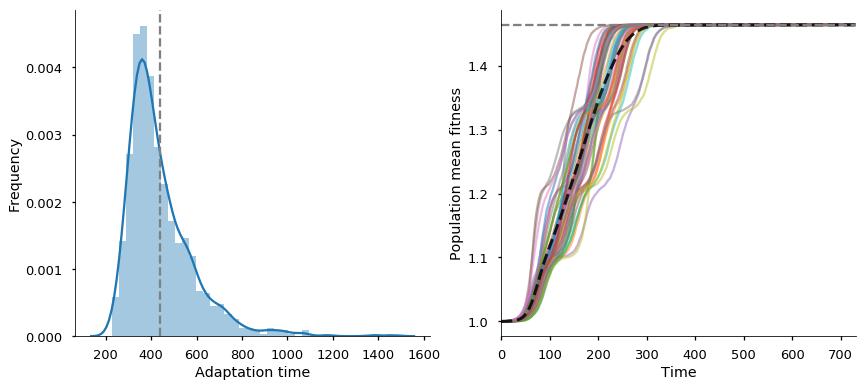

In [390]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.distplot(times, ax=ax[0])
ax[0].axvline(times.mean(), color='gray', ls='--')
ax[0].set(xlabel='Adaptation time', ylabel='Frequency')

pivoted.plot(ax=ax[1], alpha=0.5)
mean_df.plot('Time', 'Fitness', color='k', alpha=0.85, ls='--', lw=3, ax=ax[1])
ax[1].axhline((1 + s)**(L - 1) * (1 - 2 * m), color='gray', ls='--')
ax[1].legend().set_visible(False)
ax[1].set(ylabel='Population mean fitness', xlim=(0, df.Time.max()/2))


sns.despine()

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)